# Read_tfrecords

Script aims to read tfrecords files previously created. The tfrecords files contain master_image,c1,c2,c3,id_sub. The c1,c2,c3 masks correspond to gray matter, white matter and liquour segmentation carried out on CTseg. 'id_sub' corresponds to subject id_number

### Import packages


In [1]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import boto3
import os
import glob
import zipfile
import shutil
import keras
import tensorflow as tf
from functools import partial
from keras import backend as K
from sklearn.metrics import jaccard_score
import statistics

### Get tfrecords files

In [2]:
tfrecords_dir= '/volumed/Artur2/tf_recods_files'
file_names = tf.io.gfile.glob('/volumed/Artur2/tf_recods_files/*')
len(file_names)

17

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
#defining the batch size
BATCH_SIZE = 1


In [6]:
def decode_image(image,image_type):
    """serilize to numpy array""" 
    image_string = tf.io.parse_tensor(image, out_type=image_type)
    feature = tf.reshape(image_string, shape=[256, 256, 256])
    return feature
    
    

def read_tfrecord(example):
    """reading master image, c2,c3,c3, subject id, age and sex features""" 
    feature_description ={
        "master_image": tf.io.FixedLenFeature([],tf.string),
        "c1": tf.io.FixedLenFeature([],tf.string),
        "c2": tf.io.FixedLenFeature([],tf.string),
        "c3": tf.io.FixedLenFeature([],tf.string),
        "sub": tf.io.FixedLenFeature([],tf.string),
        "age": tf.io.FixedLenFeature([],tf.string),
        "sex": tf.io.FixedLenFeature([],tf.string)
        
        }
  
    example = tf.io.parse_single_example(example,feature_description ) #spliting the data into one subject
    master_image = decode_image(example["master_image"],tf.int16) #decoding string into nparray
    c1 = decode_image(example["c1"],tf.uint8) #decoding string into nparray
    c2= decode_image(example["c2"],tf.uint8) #decoding string into nparray
    c3 = decode_image(example["c3"],tf.uint8) #decoding string into nparray
    id_sub = tf.cast(example["sub"], tf.string)        
    age= tf.cast(example["age"], tf.string) 
    sex = tf.cast(example["sex"], tf.string)     
    #return master_image,[c1,c2,c3]
    return master_image,c1

    
def load_dataset(filenames):
    """loading dataset""" 
    #By ignoring the order and reading files as soon as they come in, it will take a shorter time to load the data.
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(partial(read_tfrecord), num_parallel_calls=AUTOTUNE)
    return dataset

def get_dataset(filenames):
    """function to get our different datasets""" 
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset




    

In [7]:
dataset=get_dataset(file_names)

### Test if images were decoded correctly

In [8]:
master_image,c1 = next(iter(dataset))

In [9]:
c1_image=c1.numpy()

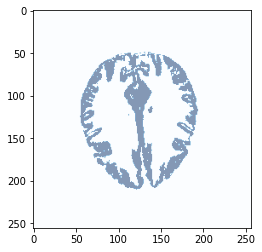

In [12]:
plt.imshow(c1_image[0,150,:,:],cmap='Blues', alpha=0.5)
# plt.imshow(c2[1,150,:,:],cmap='Reds',alpha=0.5)
# plt.imshow(c3[1,150,:,:],cmap='Purples',alpha=0.5)

### Train model



In [16]:
os.chdir('/volumed/Artur2/')


In [17]:
from model3D import ModelSegmentation

# Classes to create the model and load the weights. Related to requirements ZKDP06, ZKVS01, and ZKBS07.
#     =======================================================================================================
#     Input parameters:
#         - image_size: integer referring to the dimension of the model input image;
#         - num_class: integer referring to the number of classes to be segmented by the model. By default is 3;
#         - model_weigths: string for the path and name of the H5 file for the model weights, by default is 
#                          None;
#         - bacth_norm: boolean variable, if true, Batch Normalization layers are added to the model 
#                       architecture. By default it is True.
#     =======================================================================================================


teste = ModelSegmentation(256,1,None,True)

In [18]:
modelo=teste.ИNet()

In [19]:
modelo.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 25 0                                            
__________________________________________________________________________________________________
conv3d_32 (Conv3D)              (None, 256, 256, 256 112         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 256, 256, 256 16          conv3d_32[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 256, 256, 256 0           batch_normalization_26[0][0]     
____________________________________________________________________________________________

### Definir métrica Dice e loss Dice


In [14]:
## VERIFICAR FUNÇÃO DICE!!!!

def dice_metric(y_true, y_pred): # No gamma, no smooth
#     y_true=y_true.astype(float)
#     y_pred=y_pred.astype(float)
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / denominator



def dice_loss(y_true,y_pred):
    return 1-dice_metric(y_true,y_pred)



def jaccard_similarity_score(y_true,y_pred):
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    # Compute the intersection using 2 * tf.reduce_sum(y_true * y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)

    # Compute the denominator using tf.reduce_sum
    denominator = tf.reduce_sum((y_true + y_pred) - intersection)

    # Compute the Jaccard coefficient by dividing the intersection by the denominator
    jaccard_coefficient = 2*intersection / denominator

    return jaccard_coefficient

def jaccard_loss(y_true,y_pred):
    return 1-jaccard_similarity_score(y_true,y_pred)


# def custom_loss(y_true, y_pred)



### testing custom_metric

In [31]:
# def custom_metric (y_true,y_pred):
#     y_true=sitk.GetImageFromArray(y_true)
#     y_pred=sitk.GetImageFromArray(y_pred)
#     overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
#     hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
#     overlap_measures_filter.Execute(y_true, y_pred)
#     jaccard=overlap_measures_filter.GetJaccardCoefficient()
#     dice=overlap_measures_filter.GetDiceCoefficient()
#     housdorff=hausdorff_distance_filter.GetHausdorffDistance()
    
#     metric= statistics.median([jaccard,dice,housdorff])
#     return metric
    
# def custom_loss(y_true,y_pred):
#     return 1-custom_metric(y_true,y_pred)
    
    


In [38]:
# custom_loss( c1_image[7,:,:,:],c1_image[0,:,:,:])

0.65382630235269

### Compilar o modelo usando otimizador Adam


In [20]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001) 

modelo.compile(optimizer=adam, loss=dice_loss, metrics=[dice_metric])

### Treinar o modelo

In [ ]:
modelo.fit(dataset, epochs=1, batch_size=1, verbose=2 )


In [ ]:
!cd